In [6]:
import numpy as np
import matplotlib.pyplot as mp
import scipy.fftpack as fft
import scipy.io.wavfile as wav
import scipy.stats as stat
import numpy.linalg as la
import numpy.random as rd
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error as mse
import cvxpy as cvx
import IPython.display as disp
import joblib as jl
import time, h5py, warnings
from tqdm import tqdm_notebook, tnrange
import datetime as date
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
mp.style.use("seaborn-poster")
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (5*16/9,5)
mp.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]
mp.rcParams["figure.dpi"] = 100
rd.seed(314)

In [3]:
"""Implementation of the Smoothed L0 Optimisation algorithm developed by Mohimani et al, see http://ee.sharif.edu/~SLzero/ for details."""

def gaussian_F(x_i, sigma):
    """Calculate the maximisation function f_{sigma} for an element of the vector x"""
    x = np.abs(x_i)
    return x_i * np.exp(-1*x*x/(2*sigma*sigma))

Fsigma_gauss = np.vectorize(gaussian_F, otypes=[np.float_]) #Vectorize the gaussian function

def SL0(A, b, **kwargs):
    """Function that performs the SL0 algorithm given the matrix A and b, and a minimum value of sigma.
    Arguments: 
     - A: numpy matrix
     - b: numpy matrix
     - sigma_min: Float, minimum value of the approximation parameter sigma. A sensible default is 1e-12
    Optional keyword arguments:
    - FSigma: vectorized function that takes an element of a vector, and the parameter sigma, as arguments. Defaults to
    the Gaussian form used by the authors
    - L: Number of steps of the gradient ascent step, defaults to 3
    - mu_0: Gradient in the gradient ascent step, defaults to 2
    - sigma_decrease: Amount by which the approximation parameter decreases each step
    """
    #Defaults for mu_0, L, decrease factor taken from the paper
    Fsigma = kwargs.pop('Fsigma', Fsigma_gauss)
    sigma_min = kwargs.pop("sigma_min", 1e-12)
    mu_0 = kwargs.pop('mu_0', 2)
    L = kwargs.pop('L', 3)
    sdf = kwargs.pop('sigma_decrease',0.5)
    A_plus = np.linalg.pinv(A)
    x = A_plus.dot(b)
    sigma = 2*np.max(np.abs(x))
    while sigma > sigma_min:
        for i in range(L): #Do L rounds of gradient ascent
            delta = Fsigma(x, sigma)
            x -= mu_0*delta
            x -= A_plus.dot(A.dot(x) - b)
        sigma *= sdf #Sigma decrease factor value chosen b the authors
    return np.around(x, decimals=10)

def get_frequency(ft, samprate):
    return np.argmax(abs(ft))/len(ft)*samprate

In [4]:
class compsenseFromFile:
    
    def __init__(self, filename, downsample=False, downrate=None):
        self.rate, self.data = wav.read(filename)
        self.dtype = self.data.dtype
        self.filename = filename
        self.name = filename[:-4]
        
        if len(self.data.shape) > 1 and self.data.shape[1] > 1:
            self.data = self.data.mean(axis=1)
            
        self.N = len(self.data)
        self.dur = self.N/self.rate
        self.t = np.linspace(0, self.dur, self.N)
        self.coef = fft.fft(self.data)
        self.coefshift = fft.fftshift(self.coef)
        
        if downsample:
            self.downrate = downrate
            self.Nd = int(downrate*self.dur)
            nd = np.round(np.linspace(0, self.N-1, self.Nd)).astype(int)
            self.data = self.data[nd]
            self.t = self.t[nd]
            self.coef = fft.fft(self.data)
            self.coefshift = fft.fftshift(self.coef)
            self.rate = downrate
        else:
            self.Nd = self.N
            self.t = np.linspace(0, self.dur, self.Nd)
        
    def getDominantFrequency(coef, rate):
        return np.argmax(abs(coef))/len(coef)*rate
        
    def displayOriginal(self, save=False):
        fig = mp.figure(figsize=(5*16/9*2, 5))

        ax = fig.add_subplot(121)
        ax.plot(self.t, self.data, "c-", lw=0.4)
        ax.set_xlabel("time, s")
        ax.set_ylabel("amplitude")
        ax.set_title("original signal, $f_s = %i$Sa/s"%(self.rate))

        f = np.linspace(0, self.rate, self.Nd)
        ax = fig.add_subplot(122)
        ax.plot(f[:self.Nd//2], abs(self.coef)[:self.Nd//2], "c-")
        ax.set_xlabel("frequency, Hz")
        ax.set_ylabel("density")
        ax.set_title("Frequency spectrum")
        
        if save:
            mp.savefig(self.name + "_original.png", dpi=300, bbox_inches="tight", transparent=True)

        mp.show()
        disp.Audio(self.data, rate=self.rate)
        
    def sampleCompressive(self, mode, rate):
        self.subrate = rate
        self.M = int(self.subrate*self.dur)
        
        if mode == "random":
            m = np.sort(rd.randint(0, self.Nd, self.M))
        elif mode == "subnyquist":
            m = np.round(np.linspace(0, self.Nd-1, self.M)).astype(int)
        else:
            raise ValueError("Specified mode is invalid")
        
        self.y = self.data[m]
        self.tm = self.t[m]
        self.compressedCoef = fft.fft(self.y)
        self.compressedCoefShift = fft.fftshift(self.compressedCoef)
        self.m = m
        
    def displayCompressed(self, save=False):
        y = self.to_int16(self.y)
        
        fig = mp.figure(figsize=(5*16/9*2, 5))

        ax = fig.add_subplot(121)
        ax.plot(self.tm, y, "c-", lw=0.4)
        ax.set_xlabel("time, s")
        ax.set_ylabel("amplitude")
        ax.set_title("compressively sampled signal")

        f = np.linspace(0, self.subrate, self.M)
        ax = fig.add_subplot(122)
        ax.plot(f[:self.M//2], abs(self.compressedCoef)[:self.M//2], "c-")
        ax.set_xlabel("frequency, Hz")
        ax.set_ylabel("density")
        ax.set_title("Frequency spectrum")

        if save:
            mp.savefig(self.name + "_comp.png", dpi=300, bbox_inches="tight", transparent=True)
            wav.write(self.name + "_comp.wav", self.subrate, y)
        
        mp.show()
        disp.Audio(y, rate=self.subrate)
    
    def recovery(self, method, **method_kwargs):
        self.method = method
        d = fft.dct(np.identity(self.Nd))
        A = d[self.m]
        
        if method == "lasso":
            prob = skl.Lasso(**method_kwargs)
        elif method == "lassocv":
            prob = skl.LassoCV(**method_kwargs)
        elif method == "omp":
            prob = skl.OrthogonalMatchingPursuit(**method_kwargs)
        elif method == "sl0":
            prob = SL0(A, self.y)
            self.recoveredCoef = prob
            self.xhat = self.to_int16(fft.idct(prob))
            return
        else:
            raise ValueError("Specified method is invalid")
        
        prob.fit(A, self.y)
        self.recoveredCoef = prob.coef_
        self.xhat = self.to_int16(fft.idct(prob.coef_))
            
    def displayRecovered(self, save):
        #xhat = fft.idct(self.recoveredCoef)
        #xhat = self.to_int16(xhat)
        xhat = self.xhat
        
        fig = mp.figure(figsize=(5*16/9*2, 5))

        ax = fig.add_subplot(121)
        ax.plot(self.t, xhat, "c-", lw=0.4)
        ax.set_xlabel("time, s")
        ax.set_ylabel("amplitude")
        ax.set_title("reconstructed signal")

        f = np.linspace(0, self.rate, self.Nd)
        ax = fig.add_subplot(122)
        ax.plot(f[:self.Nd//2], abs(self.recoveredCoef)[:self.Nd//2], "c-")
        ax.set_xlabel("frequency, Hz")
        ax.set_ylabel("density")
        ax.set_title("Frequency spectrum")

        if save:
            mp.savefig(self.name + "_recon_" + self.method + ".png", dpi=300, bbox_inches="tight", transparent=True)
            wav.write(self.name + "_recon_" + self.method + ".wav", self.rate, xhat)
        
        mp.show()
        disp.Audio(self.y, rate=self.rate)
        self.xhat = xhat
        
    def to_int16(self, sig):
        return np.round(sig/abs(sig).max() * ((2**16 - 1)//2)).astype("int16")
    
    def get_psnr(self):
        return 20*np.log10((2**16/2 - 1)/np.sqrt(mse(self.data, self.xhat)))
        
    def run_all(self, mode, rate, save, method, **method_kwargs):
        #self.displayOriginal(save)
        self.sampleCompressive(mode, rate)
        #self.displayCompressed(save)
        self.recovery(method, **method_kwargs)
        #self.displayRecovered(save)

In [5]:
maxiters = 10
percentSamples = np.arange(0.1, 0.51, 0.1)
processTime = np.zeros((3, len(percentSamples)), float)
psnrList = np.zeros_like(processTime, float)
mseList_lasso = np.zeros((maxiters, len(percentSamples)), float)
mseList_omp = np.zeros_like(mseList_lasso, float)
mseList_sl0 = np.zeros_like(mseList_lasso, float)
methodList = ["lasso", "omp", "sl0"]

In [6]:
pbar = tqdm_notebook(methodList)
start_time = time.time()
for m,t in enumerate(pbar):
    pbar.set_description("Using algorithm %s" %t)
    
    for k in tnrange(maxiters, desc="Stochastic iteration"):
    #     print("{0}: iteration {1}/{2}".format(date.datetime.now(), k+1, maxiters))
        
        for s in tnrange(len(percentSamples), desc="percentage of samples", leave=False):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                E1L = compsenseFromFile("E1.wav")
    #         if i == 0:
    #             print("{0}: Process start".format(date.datetime.now()))
            t0 = time.time()
            if m == 0:
                E1L.run_all("random", (percentSamples[s]*len(E1L.data))//32, False, methodList[m], alpha=1.0)
            else:
                E1L.run_all("random", (percentSamples[s]*len(E1L.data))//32, False, methodList[m])
            t1 = time.time()
    #         hours, rem = divmod(t1-t0, 3600)
    #         minutes, seconds = divmod(rem, 60)
    #         print("{0}: LASSO, {1} ({2}%) samples, {3:0>2}:{4:0>2}:{5:05.2f} elapsed, {6:.2f}% done".format(date.datetime.now(), 
    #                                                     int(s*len(E1L.data)), int(s*100), int(hours), int(minutes), seconds, 100*i/len(percentSamples)))
            processTime[m,s] += t1-t0
            psnrList[m,s] += E1L.get_psnr()
            
            if m == 0:
                mseList_lasso[k,s] = mse(E1L.data, E1L.xhat)
            elif m == 1:
                mseList_omp[k,s] = mse(E1L.data, E1L.xhat)
            else:
                mseList_sl0[k,s] = mse(E1L.data, E1L.xhat)

    #         if s == len(percentSamples):
    #             print("{0}: LASSO, {1} ({2}%) samples, {3:0>2}:{4:0>2}:{5:05.2f} elapsed, {6:.2f}% done".format(date.datetime.now(), 
    #                                                     int(s*len(E1L.data)), int(s*100), int(hours), int(minutes), seconds, 100*i/len(percentSamples)))
            np.save("time.npy", processTime)
            np.save("psnr.npy", psnrList)
            np.save("mselasso.npy", mseList_lasso)
            np.save("mseomp.npy", mseList_omp)
            np.save("msesl0.npy", mseList_sl0)
    
end_time = time.time()
np.save("time.npy", processTime)
np.save("psnr.npy", psnrList)
np.save("mselasso.npy", mseList_lasso)
np.save("mseomp.npy", mseList_omp)
np.save("msesl0.npy", mseList_sl0)

hours, rem = divmod(end_time-start_time, 3600)
minutes, seconds = divmod(rem, 60)
print("{0}: Done. Total time: {1:0>2}:{2:0>2}:{3:05.2f}".format(date.datetime.now(), int(hours), int(minutes), seconds))

Stochastic iteration:   0%|                             | 0/10 [00:00<?, ?it/s]

percentage of samples:   0%|                             | 0/5 [00:00<?, ?it/s]C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


percentage of samples:  20%|████▏                | 1/5 [00:36<02:26, 36.56s/it]

percentage of samples:  40%|████████▍            | 2/5 [01:18<01:54, 38.02s/it]

percentage of samples:  60%|████████████▌        | 3/5 [02:06<01:22, 41.11s/it]

percentage of samples:  80%|████████████████▊    | 4/5 [02:56<00:43, 43.72s/it]

percentage of samples: 100%|█████████████████████| 5/5 [03:47<00:00, 46.04s/it]

                                                                               
Stochastic iteration:  10%|██                  | 1/10 [03

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in sqrt


percentage of samples:  60%|████████████▌        | 3/5 [03:07<01:48, 54.24s/it]C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)


percentage of samples:  80%|████████████████▊    | 4/5 [05:00<01:11, 71.86s/it]C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)


percentage of samples: 100%|████████████████████| 5/5 [07:56<00:00, 103.24s/it]

                                  



percentage of samples:  20%|████▏                | 1/5 [00:27<01:50, 27.65s/it]C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in sqrt


percentage of samples:  40%|████████▍            | 2/5 [01:11<01:37, 32.46s/it]C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)


percentage of samples:  60%|████████████▌        | 3/5 [02:18<01:26, 43.00s/it]C:\Users\Porites\Anaconda3\envs\comp

2019-04-12 12:38:49.356356: Done. Total time: 02:44:35.71


In [8]:
mseList_lasso = np.load("mselasso.npy")
processTime = np.load("time.npy")
psnrList = np.load("psnr.npy")
mseList_lasso = np.load("mselasso.npy")
mseList_omp = np.load("mseomp.npy")
mseList_sl0 = np.load("msesl0.npy")

In [9]:
mmse_lasso = mseList_lasso.mean(axis=0)
sdList_lasso = mmse_lasso.std(axis=0)
sdomList_lasso = sdList_lasso/len(mmse_lasso.T)

mmse_omp = mseList_omp.mean(axis=0)
sdList_omp = mmse_omp.std(axis=0)
sdomList_omp = sdList_omp/len(mmse_omp.T)

mmse_sl0 = mseList_sl0.mean(axis=0)
sdList_sl0 = mmse_sl0.std(axis=0)
sdomList_sl0 = sdList_sl0/len(mmse_sl0.T)

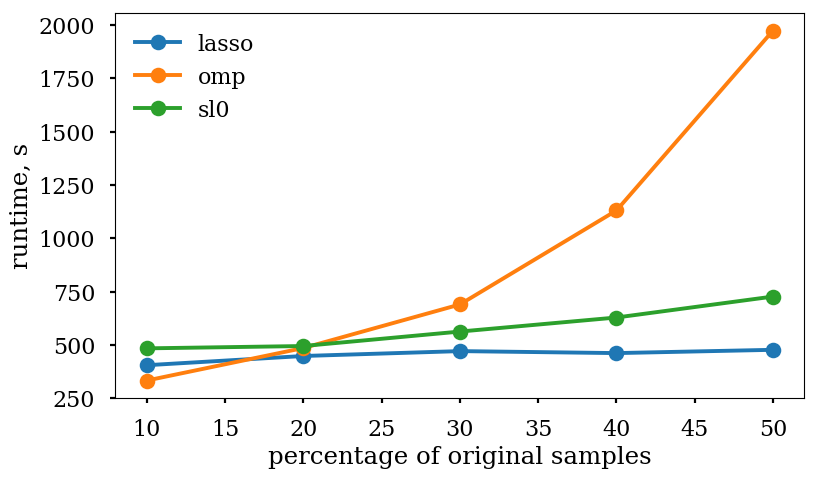

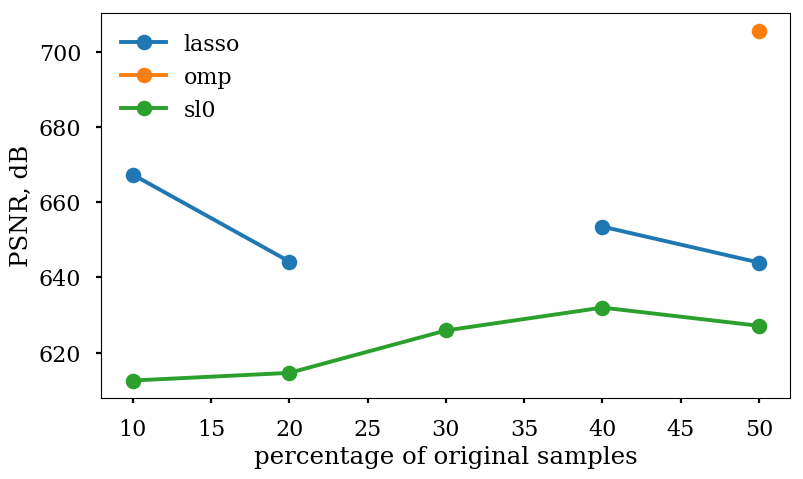

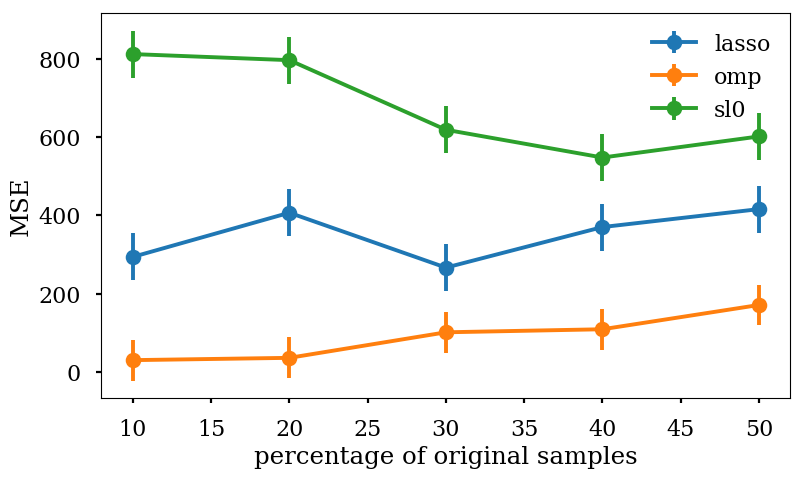

In [11]:
for i in range(3):
    mp.plot((percentSamples*100).astype(int), processTime[i], "o-", label=methodList[i])
#     mp.grid(True)
    mp.xlabel("percentage of original samples")
    mp.ylabel("runtime, s")
    mp.legend(framealpha=0)
# mp.savefig("processtime.png", dpi=300, bbox_inches="tight")
mp.show()

for i in range(3):
    mp.plot((percentSamples*100).astype(int), psnrList[i], "o-", label=methodList[i])
#     mp.grid(True)
    mp.xlabel("percentage of original samples")
    mp.ylabel("PSNR, dB")
    mp.legend(framealpha=0)
# mp.savefig("psnr.png", dpi=300, bbox_inches="tight")
mp.show()

mp.errorbar((percentSamples*100).astype(int), mmse_lasso, sdList_lasso, None, "o-", label="lasso", capsize=2)
mp.errorbar((percentSamples*100).astype(int), mmse_omp, sdList_omp, None, "o-", label="omp", capsize=2)
mp.errorbar((percentSamples*100).astype(int), mmse_sl0, sdList_lasso, None, "o-", label="sl0", capsize=2)
# mp.grid(True)
mp.xlabel("percentage of original samples")
mp.ylabel("MSE")
mp.legend(framealpha=0)
# mp.savefig("mse.png", dpi=300, bbox_inches="tight")
mp.show()